In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/train.csv')


In [3]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Lets see the data for a single item over three years

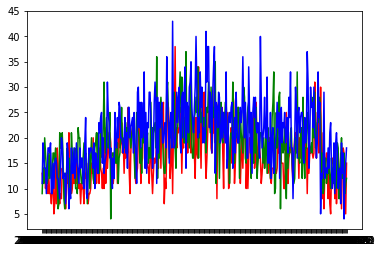

In [4]:
plt.plot(data.date.values[:365], data.sales.values[:365], 'r', data.date.values[:365], data.sales.values[365:730], 'g', data.date.values[:365], data.sales.values[730:1095], 'b')

There is clearly some pattern in the data.

In [5]:
data.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

Changing index to date column for easy access.

In [7]:
data = pd.read_csv('data/train.csv', parse_dates=['date'], index_col='date',date_parser=dateparse)

In [8]:
data.dtypes

store    int64
item     int64
sales    int64
dtype: object

In [9]:
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [10]:
data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=913000, freq=None)

In [11]:
data['2013'].head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [12]:
filtered_data = data[(data['store'] == 1) & (data['item'] == 1)]

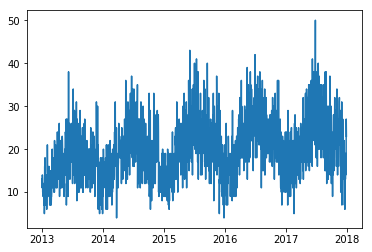

In [13]:
plt.plot(filtered_data.index, filtered_data.sales.values)

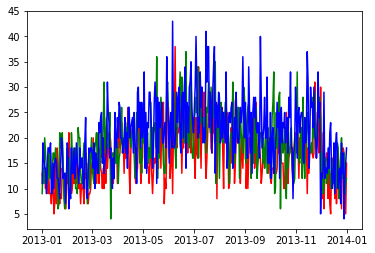

In [14]:
plt.plot(filtered_data['2013'].index, filtered_data['2013'].sales.values, 'r', filtered_data['2013'].index, filtered_data['2014'].sales.values, 'g', filtered_data['2013'].index, filtered_data['2015'].sales.values, 'b')